# Disaster Response Message Classification

Disaster message classification is a model that will be used to filter information received from various sources by the organization for further handling according to the needs and requests for assistance needed.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import re
import string

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Dataset

The data that used is text data that has been collected by figure-eight or what is now known as appen.

In [ ]:
messages = pd.read_csv("messages.csv")
categories = pd.read_csv("categories.csv")

In [ ]:
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [ ]:
#get only id and message from messages
messages = messages[['id', 'message']]
messages.head()

,id,message
0,2,Weather update - a cold front from Cuba that c...
1,7,Is the Hurricane over or is it not over
2,8,Looking for someone but no name
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...
4,12,"says: west side of Haiti, rest of the country ..."


In [ ]:
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [ ]:
df_categories = categories.categories.str.split(';', expand=True)
df_categories.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [ ]:
category_colnames = ('related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_product', 'search_and_resque', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastucture_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report')
df_categories.columns = category_colnames
df_categories.head()


,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [ ]:
for column in df_categories:
    # set each value to be the last character of the string
    df_categories[column] = df_categories[column].str[-1]
    
    # convert column from string to numeric
    df_categories[column] = pd.to_numeric(df_categories[column])
df_categories.head()

,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_all= pd.merge(messages, df_categories, left_index=True, right_index=True)
data_all.head()


,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train, test = train_test_split(data_all, test_size = 0.2)

In [ ]:
train.head()

,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
6247,7099,I would like to register for that plan.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20714,24072,23: A Sudanese criminal court sentenced eight ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11115,12766,Sandy is causing up a stir .. . Got ta get rea...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
5734,6533,Is there another message to tell me I'm signed...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20919,24294,These logs smashed scores of frail tin-roofed ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
1408,1652,"please we need water, food and tents, we have ...",1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17119,20081,Mosquito nets are also a big need to protect t...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20195,23488,The attack comes three days after two grenade ...,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20426,23752,Whereas in 1977 women comprised more than 15 p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7083,7996,YOUR INFORMATION ABOUT TEMPERATURE.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis


EDA was conducted to determine the percentage of each category. However, the sample data used is only 9 data categories.

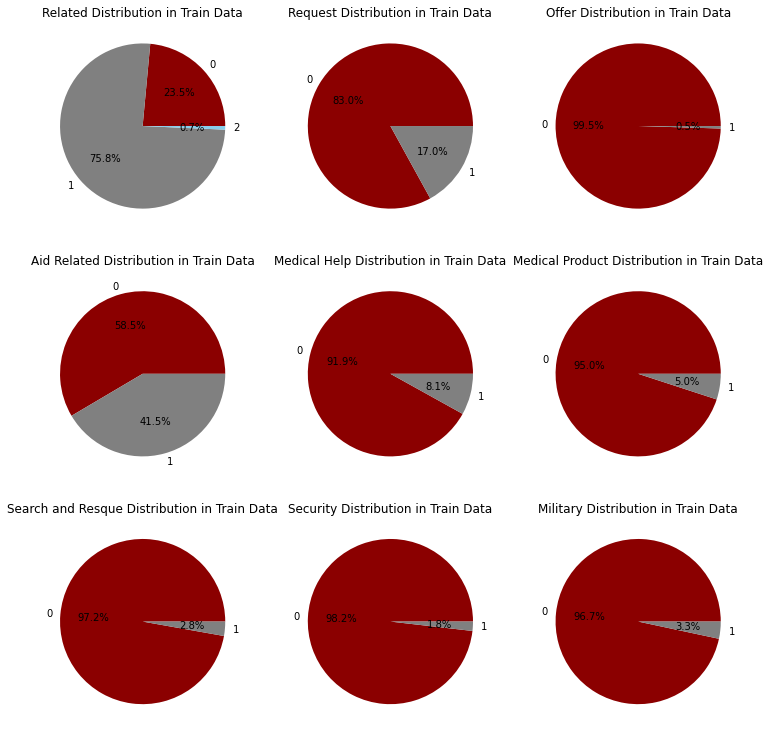

In [ ]:
figure3 = plt.figure()
figure3.subplots_adjust(bottom=0.025, left=0.025, top=1.975, right= 1.975)

plt.subplot(3, 3, 1)
train.groupby('related').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Related Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 2)
train.groupby('request').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Request Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 3)
train.groupby('offer').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Offer Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 4)
train.groupby('aid_related').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Aid Related Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 5)
train.groupby('medical_help').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Medical Help Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 6)
train.groupby('medical_product').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Medical Product Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 7)
train.groupby('search_and_resque').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Search and Resque Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 8)
train.groupby('security').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Security Distribution in Train Data')
plt.ylabel('')

plt.subplot(3, 3, 9)
train.groupby('military').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Military Distribution in Train Data')
plt.ylabel('')

plt.show()

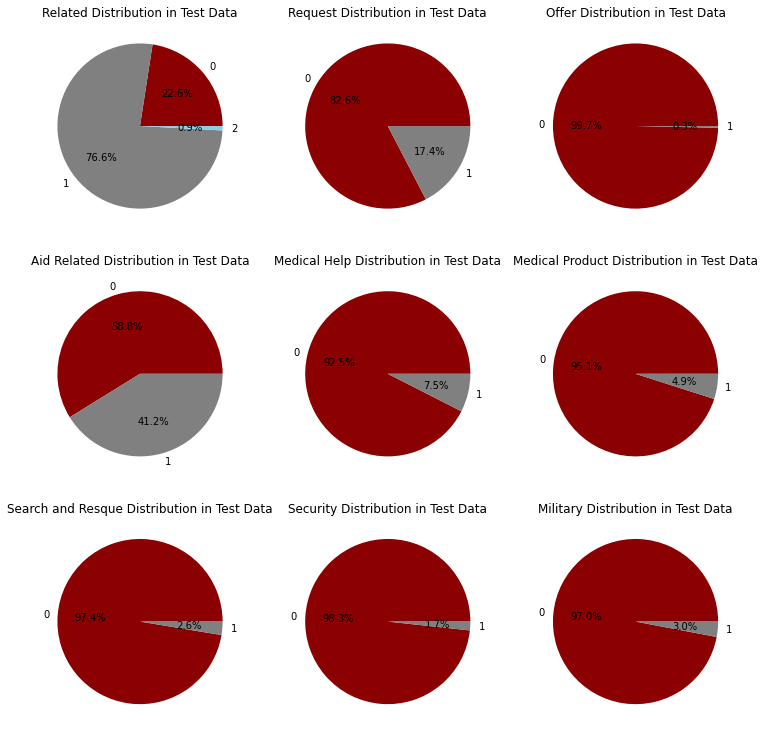

In [ ]:
figure3 = plt.figure()
figure3.subplots_adjust(bottom=0.025, left=0.025, top=1.975, right= 1.975)

plt.subplot(3, 3, 1)
test.groupby('related').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'],figsize=(5,5))
plt.title('Related Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 2)
test.groupby('request').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Request Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 3)
test.groupby('offer').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Offer Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 4)
test.groupby('aid_related').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Aid Related Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 5)
test.groupby('medical_help').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Medical Help Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 6)
test.groupby('medical_product').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Medical Product Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 7)
test.groupby('search_and_resque').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Search and Resque Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 8)
test.groupby('security').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Security Distribution in Test Data')
plt.ylabel('')

plt.subplot(3, 3, 9)
test.groupby('military').size().plot(kind='pie',autopct='%1.1f%%',colors = ['darkred', 'gray', 'skyblue'], figsize=(5,5))
plt.title('Military Distribution in Test Data')
plt.ylabel('')

plt.show()




## Data Preparation


Text cleaning carried out includes:
1. Remove mentions
2. Remove newline character
3. Remove multiple spaces
4. Remove hashtags
5. Remove non utf8/ascii characters
6. Remove punctuation
7. Make lower case text
8. Remove any spaces at the start or end of the text
9. Remove stopwards

In [ ]:
#data cleaning

def text_cleaner(text):
    mention_pat= r'@[A-Za-z0-9_]+'
    mention_2_pat=r'@[A-Za-z0-9_]+:\s'
    
    #Remove mention
    text = re.sub(mention_2_pat,'', text)
    text = re.sub(mention_pat,'', text)

    #Remove newline characters 
    text = text.replace('\n', ' ') 

    #Remove multiple spaces
    text = re.sub("\s\s+" , " ", text)

    #Remove hashtag
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    text = " ".join(word.strip() for word in re.split('#|_', text)) #remove just the hashtags (#) symbol from words in the middle of the sentence

    #Remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    #Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    #Lowercase
    text = text.lower()

    #Remove any spaces at the start or end of the text
    text = text.strip()

    return text

In [ ]:
print(train['message'].iloc[1])
print(text_cleaner(train['message'].iloc[1]))

23: A Sudanese criminal court sentenced eight people, including two women, to jail terms of up to five years for running a ring smuggling young women to Syria.
23 a sudanese criminal court sentenced eight people including two women to jail terms of up to five years for running a ring smuggling young women to syria


In [ ]:
print(train['message'].iloc[1500])
print(text_cleaner(train['message'].iloc[1500]))

We are in need of help. We are in Croix de Bouquet around the National 1 
we are in need of help we are in croix de bouquet around the national 1


In [ ]:
#Apply text_cleaner on all train & test data

train['message'] = train['message'].apply(text_cleaner)
test['message'] = test['message'].apply(text_cleaner)

In [ ]:
train.head()

,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
6247,7099,i would like to register for that plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20714,24072,23 a sudanese criminal court sentenced eight p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11115,12766,sandy is causing up a stir got ta get ready ...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
5734,6533,is there another message to tell me im signed up,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20919,24294,these logs smashed scores of frail tinroofed b...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
1408,1652,please we need water food and tents we have 10...,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17119,20081,mosquito nets are also a big need to protect t...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20195,23488,the attack comes three days after two grenade ...,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20426,23752,whereas in 1977 women comprised more than 15 p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7083,7996,your information about temperature,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
def remove_stopwords(text):
    text_split = text.split() 
    text_split = [x for x in text_split if x not in stopwords_list] 
    text = ' '.join(text_split) 
    return text.strip()

In [ ]:
# Remove stopwords from the message and save into a new column

train['clean_message'] = train['message'].apply(remove_stopwords)
test['clean_message'] = test['message'].apply(remove_stopwords)

In [ ]:
train.head()

,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,clean_message
6247,7099,i would like to register for that plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,would like register plan
20714,24072,23 a sudanese criminal court sentenced eight p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23 sudanese criminal court sentenced eight peo...
11115,12766,sandy is causing up a stir got ta get ready ...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,sandy causing stir got ta get ready first show...
5734,6533,is there another message to tell me im signed up,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,another message tell im signed
20919,24294,these logs smashed scores of frail tinroofed b...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,logs smashed scores frail tinroofed bamboo hom...


In [ ]:
test.head()

,id,message,related,request,offer,aid_related,medical_help,medical_product,search_and_resque,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastucture_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,clean_message
1408,1652,please we need water food and tents we have 10...,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,please need water food tents 101 chlidren plea...
17119,20081,mosquito nets are also a big need to protect t...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,mosquito nets also big need protect people ano...
20195,23488,the attack comes three days after two grenade ...,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,attack comes three days two grenade blasts nai...
20426,23752,whereas in 1977 women comprised more than 15 p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,whereas 1977 women comprised 15 percent loya j...
7083,7996,your information about temperature,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,information temperature


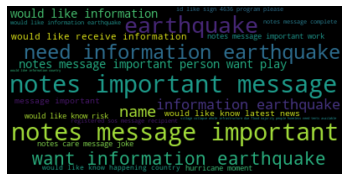

In [ ]:
data = train['clean_message'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

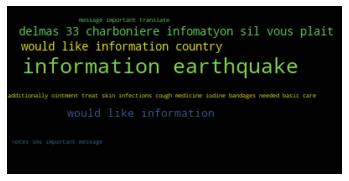

In [ ]:
data = test['clean_message'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Modelling

Some of the models that are tried to be applied to the data include:
1. MultinomialNB
2. DecisionTreeClassifier
3. RandomForestClassifier


however, from the results obtained MultinomialNB gives more optimal results compared to the other two models.

In [ ]:
vectorizer = CountVectorizer()
X_train_BoW = vectorizer.fit_transform(train['clean_message'].to_list()) 
X_test_BoW = vectorizer.transform(test['clean_message'].to_list()) 

In [ ]:
print(X_train_BoW.shape)

(20998, 34342)


In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['related'])
test_pred = clf.predict(X_test_BoW)

In [ ]:
print(classification_report(test['related'],test_pred))

              precision    recall  f1-score   support

           0       0.69      0.48      0.57      1185
           1       0.85      0.94      0.89      4020
           2       0.77      0.38      0.51        45

    accuracy                           0.83      5250
   macro avg       0.77      0.60      0.66      5250
weighted avg       0.82      0.83      0.82      5250



In [ ]:
clf = DecisionTreeClassifier(random_state=0).fit(X_train_BoW, train['related'])
test_pred = clf.predict(X_test_BoW)

In [ ]:
print(classification_report(test['related'],test_pred))

              precision    recall  f1-score   support

           0       0.51      0.50      0.50      1185
           1       0.85      0.86      0.85      4020
           2       0.61      0.24      0.35        45

    accuracy                           0.77      5250
   macro avg       0.66      0.53      0.57      5250
weighted avg       0.77      0.77      0.77      5250



In [ ]:
clf = RandomForestClassifier(random_state=0).fit(X_train_BoW, train['related'])
test_pred = clf.predict(X_test_BoW)

In [ ]:
print(classification_report(test['related'],test_pred))

              precision    recall  f1-score   support

           0       0.66      0.44      0.53      1185
           1       0.84      0.93      0.89      4020
           2       0.78      0.16      0.26        45

    accuracy                           0.82      5250
   macro avg       0.76      0.51      0.56      5250
weighted avg       0.80      0.82      0.80      5250



In [ ]:
vectorizer = CountVectorizer(min_df=10) 
X_train_BoW = vectorizer.fit_transform(train['clean_message'].to_list())
X_test_BoW = vectorizer.transform(test['clean_message'].to_list()) 

In [ ]:
print(X_train_BoW.shape)

(20998, 4277)


In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['related'])
test_pred = clf.predict(X_test_BoW)

In [ ]:
print(classification_report(test['related'],test_pred))

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1185
           1       0.88      0.85      0.87      4020
           2       0.38      0.29      0.33        45

    accuracy                           0.80      5250
   macro avg       0.61      0.59      0.60      5250
weighted avg       0.81      0.80      0.80      5250



In [ ]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2)) #add bi-gram to our vocab
X_train_BoW = vectorizer.fit_transform(train['clean_message'].to_list()) #fit and transform on train data
X_test_BoW = vectorizer.transform(test['clean_message'].to_list()) #used the fitted vectorizer and transform on test data

In [ ]:
print(X_train_BoW.shape)

(20998, 5324)


In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['related'])
test_pred = clf.predict(X_test_BoW)

In [ ]:
print(classification_report(test['related'],test_pred))

              precision    recall  f1-score   support

           0       0.56      0.65      0.60      1185
           1       0.88      0.85      0.87      4020
           2       0.39      0.29      0.33        45

    accuracy                           0.80      5250
   macro avg       0.61      0.60      0.60      5250
weighted avg       0.81      0.80      0.80      5250



In [ ]:
print(category_colnames)

('related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_product', 'search_and_resque', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastucture_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report')


In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['related'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['related'],test_pred))

              precision    recall  f1-score   support

           0       0.56      0.65      0.60      1185
           1       0.88      0.85      0.87      4020
           2       0.39      0.29      0.33        45

    accuracy                           0.80      5250
   macro avg       0.61      0.60      0.60      5250
weighted avg       0.81      0.80      0.80      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['request'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['request'],test_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      4338
           1       0.56      0.78      0.65       912

    accuracy                           0.85      5250
   macro avg       0.75      0.82      0.78      5250
weighted avg       0.88      0.85      0.86      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['offer'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['offer'],test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5232
           1       0.03      0.06      0.04        18

    accuracy                           0.99      5250
   macro avg       0.51      0.52      0.52      5250
weighted avg       0.99      0.99      0.99      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['aid_related'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['aid_related'],test_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      3088
           1       0.69      0.72      0.71      2162

    accuracy                           0.75      5250
   macro avg       0.74      0.75      0.75      5250
weighted avg       0.75      0.75      0.75      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['medical_help'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['medical_help'],test_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4856
           1       0.32      0.49      0.39       394

    accuracy                           0.88      5250
   macro avg       0.64      0.70      0.66      5250
weighted avg       0.91      0.88      0.90      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['medical_product'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['medical_product'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      4991
           1       0.26      0.53      0.35       259

    accuracy                           0.90      5250
   macro avg       0.62      0.73      0.65      5250
weighted avg       0.94      0.90      0.92      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['search_and_resque'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['search_and_resque'],test_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5113
           1       0.22      0.29      0.25       137

    accuracy                           0.95      5250
   macro avg       0.60      0.63      0.61      5250
weighted avg       0.96      0.95      0.96      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['security'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['security'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5160
           1       0.15      0.18      0.16        90

    accuracy                           0.97      5250
   macro avg       0.57      0.58      0.57      5250
weighted avg       0.97      0.97      0.97      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['military'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['military'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      5093
           1       0.28      0.71      0.40       157

    accuracy                           0.94      5250
   macro avg       0.64      0.83      0.68      5250
weighted avg       0.97      0.94      0.95      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['child_alone'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['child_alone'],test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5250

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['water'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['water'],test_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4929
           1       0.44      0.74      0.55       321

    accuracy                           0.93      5250
   macro avg       0.71      0.84      0.76      5250
weighted avg       0.95      0.93      0.93      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['food'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['food'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4678
           1       0.51      0.78      0.61       572

    accuracy                           0.89      5250
   macro avg       0.74      0.84      0.78      5250
weighted avg       0.92      0.89      0.90      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['clothing'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['clothing'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5173
           1       0.34      0.65      0.44        77

    accuracy                           0.98      5250
   macro avg       0.67      0.82      0.72      5250
weighted avg       0.99      0.98      0.98      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['money'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['money'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5122
           1       0.29      0.41      0.34       128

    accuracy                           0.96      5250
   macro avg       0.64      0.69      0.66      5250
weighted avg       0.97      0.96      0.96      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['missing_people'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['missing_people'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5195
           1       0.12      0.18      0.14        55

    accuracy                           0.98      5250
   macro avg       0.55      0.58      0.57      5250
weighted avg       0.98      0.98      0.98      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['refugees'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['refugees'],test_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      5063
           1       0.20      0.48      0.28       187

    accuracy                           0.91      5250
   macro avg       0.59      0.70      0.62      5250
weighted avg       0.95      0.91      0.93      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['death'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['death'],test_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      5020
           1       0.28      0.60      0.38       230

    accuracy                           0.92      5250
   macro avg       0.63      0.76      0.67      5250
weighted avg       0.95      0.92      0.93      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['other_aid'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['other_aid'],test_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4535
           1       0.40      0.36      0.38       715

    accuracy                           0.84      5250
   macro avg       0.65      0.64      0.64      5250
weighted avg       0.83      0.84      0.84      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['infrastucture_related'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['infrastucture_related'],test_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4903
           1       0.20      0.41      0.27       347

    accuracy                           0.85      5250
   macro avg       0.58      0.65      0.60      5250
weighted avg       0.91      0.85      0.88      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['transport'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['transport'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      5010
           1       0.22      0.46      0.30       240

    accuracy                           0.90      5250
   macro avg       0.60      0.69      0.62      5250
weighted avg       0.94      0.90      0.92      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['buildings'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['buildings'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      4964
           1       0.29      0.55      0.38       286

    accuracy                           0.90      5250
   macro avg       0.63      0.73      0.66      5250
weighted avg       0.94      0.90      0.92      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['electricity'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['electricity'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5139
           1       0.23      0.42      0.30       111

    accuracy                           0.96      5250
   macro avg       0.61      0.70      0.64      5250
weighted avg       0.97      0.96      0.96      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['tools'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['tools'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5218
           1       0.02      0.03      0.02        32

    accuracy                           0.98      5250
   macro avg       0.51      0.51      0.51      5250
weighted avg       0.99      0.98      0.99      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['hospitals'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['hospitals'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5181
           1       0.14      0.19      0.16        69

    accuracy                           0.97      5250
   macro avg       0.57      0.59      0.58      5250
weighted avg       0.98      0.97      0.98      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['shops'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['shops'],test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5231
           1       0.04      0.05      0.05        19

    accuracy                           0.99      5250
   macro avg       0.52      0.52      0.52      5250
weighted avg       0.99      0.99      0.99      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['aid_centers'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['aid_centers'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5183
           1       0.07      0.12      0.08        67

    accuracy                           0.97      5250
   macro avg       0.53      0.55      0.53      5250
weighted avg       0.98      0.97      0.97      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['other_infrastructure'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['other_infrastructure'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5026
           1       0.17      0.40      0.24       224

    accuracy                           0.89      5250
   macro avg       0.57      0.66      0.59      5250
weighted avg       0.94      0.89      0.91      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['weather_related'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['weather_related'],test_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3776
           1       0.68      0.73      0.70      1474

    accuracy                           0.83      5250
   macro avg       0.78      0.80      0.79      5250
weighted avg       0.83      0.83      0.83      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['floods'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['floods'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      4835
           1       0.33      0.67      0.44       415

    accuracy                           0.87      5250
   macro avg       0.65      0.78      0.68      5250
weighted avg       0.92      0.87      0.89      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['storm'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['storm'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4746
           1       0.43      0.69      0.53       504

    accuracy                           0.88      5250
   macro avg       0.70      0.80      0.73      5250
weighted avg       0.91      0.88      0.89      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['fire'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['fire'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5200
           1       0.10      0.32      0.16        50

    accuracy                           0.97      5250
   macro avg       0.55      0.65      0.57      5250
weighted avg       0.98      0.97      0.98      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['earthquake'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['earthquake'],test_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4760
           1       0.62      0.74      0.68       490

    accuracy                           0.93      5250
   macro avg       0.80      0.85      0.82      5250
weighted avg       0.94      0.93      0.94      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['cold'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['cold'],test_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5142
           1       0.21      0.53      0.30       108

    accuracy                           0.95      5250
   macro avg       0.60      0.74      0.64      5250
weighted avg       0.97      0.95      0.96      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['other_weather'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['other_weather'],test_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4970
           1       0.19      0.41      0.26       280

    accuracy                           0.88      5250
   macro avg       0.58      0.66      0.60      5250
weighted avg       0.92      0.88      0.90      5250



In [ ]:
clf = MultinomialNB().fit(X_train_BoW, train['direct_report'])
test_pred = clf.predict(X_test_BoW)

print(classification_report(test['direct_report'],test_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      4211
           1       0.49      0.73      0.59      1039

    accuracy                           0.80      5250
   macro avg       0.71      0.77      0.73      5250
weighted avg       0.84      0.80      0.81      5250





```
# This is formatted as code
```

## Conclution

the steps taken in the Disaster Response Message Classification consist of:
1. import the library that will be used
2. import csv data
3. load data messages and categories using pandas
4. check the data in each column, and only take the column that will be used
5. breakdown category into columns as needed
6. combine data message and category into 1 dataframe
7. split data into train and test
8. do EDA
9. do text cleaning
10. choose a suitable model 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1a60ae7b-9e95-489c-af87-40ab474c2732' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>